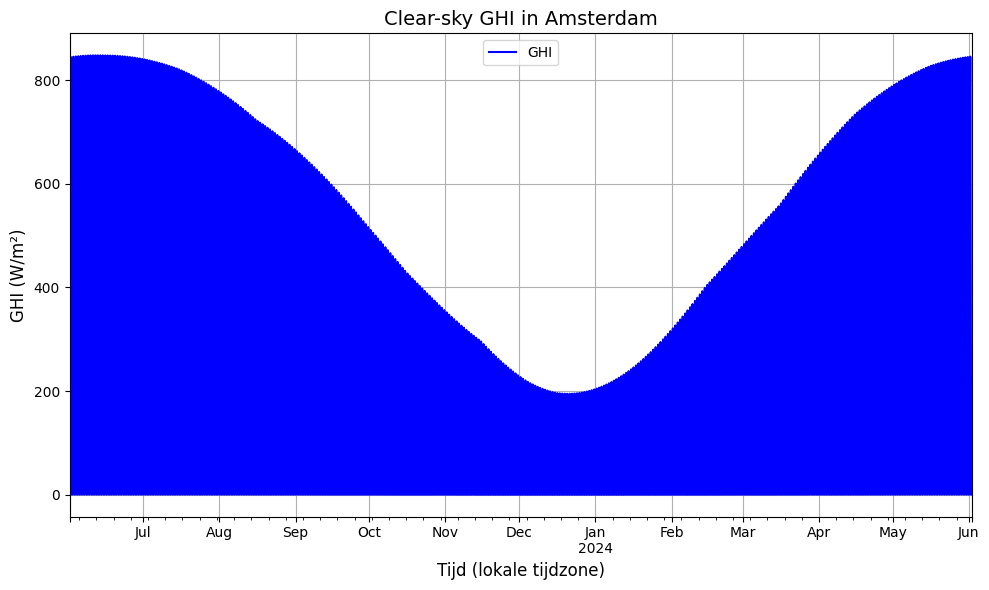

In [1]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pvlib.location import Location

# Gegevens voor Amsterdam
latitude_amsterdam = 52.3676
longitude_amsterdam = 4.9041
timezone_amsterdam = 'Europe/Amsterdam'
name_amsterdam = 'Amsterdam'

# Initialiseer locatie
location_amsterdam = Location(
    latitude=latitude_amsterdam, 
    longitude=longitude_amsterdam, 
    tz=timezone_amsterdam, 
    name=name_amsterdam
)

# Definieer de tijdstippen in UTC
times = pd.date_range(start='2023-06-01', end='2024-06-02', freq='1H', tz='UTC')

# Bereken de zonnepositie
solar_position_amsterdam = location_amsterdam.get_solarposition(times)

# Bereken de clear-sky straling met het Ineichen-model
clearsky_amsterdam = location_amsterdam.get_clearsky(times, model='ineichen')

# Converteer tijd naar lokale tijdzone
clearsky_amsterdam.index = clearsky_amsterdam.index.tz_convert(timezone_amsterdam)

# Maak een enkele plot voor de GHI
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
clearsky_amsterdam['ghi'].plot(ax=ax, label='GHI', color='blue')

# Titel, labels en grid
ax.set_title(f'Clear-sky GHI in {name_amsterdam}', fontsize=14)
ax.set_xlabel('Tijd (lokale tijdzone)', fontsize=12)
ax.set_ylabel('GHI (W/m²)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.show()

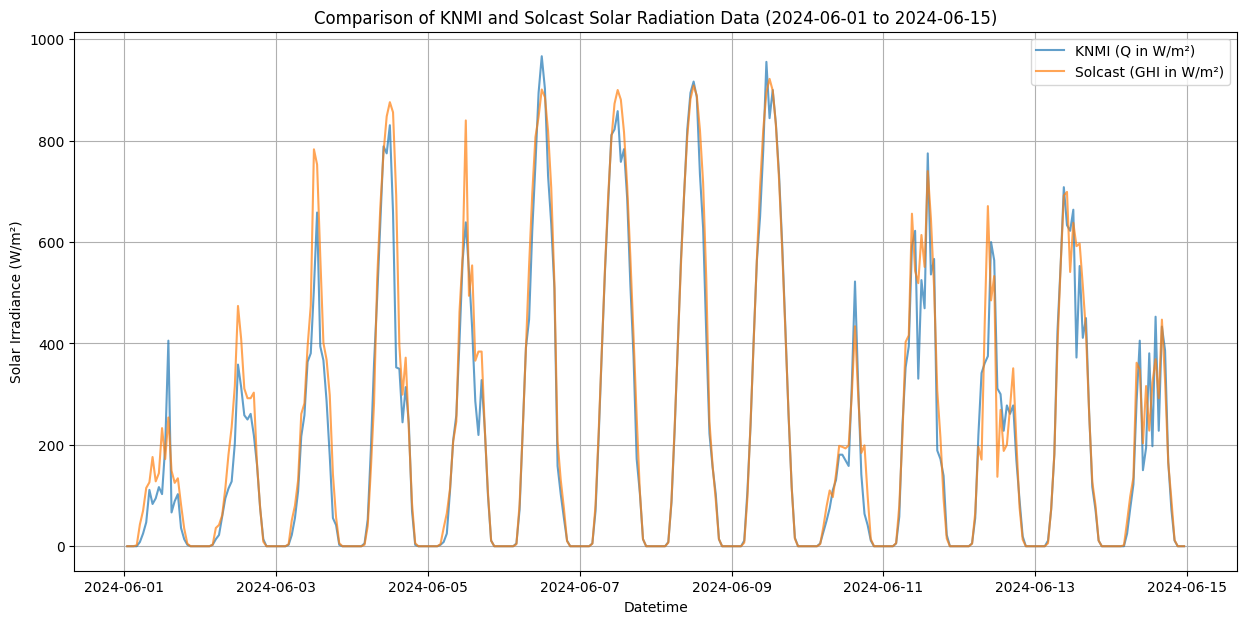

In [2]:
import Weer_data_inladen

# Load KNMI and Solcast data
knmi_data = Weer_data_inladen.load_knmi_data('data/KNMI_weerdata.txt')
solcast_data = Weer_data_inladen.load_solcast_data('data/Solcast_data_2.csv')

Weer_data_inladen.plot_comparison(knmi_data, solcast_data, '2024-06-01', '2024-06-15')

Totale jaarlijkse energieopbrengst voor Amsterdam: 408.79 kWh


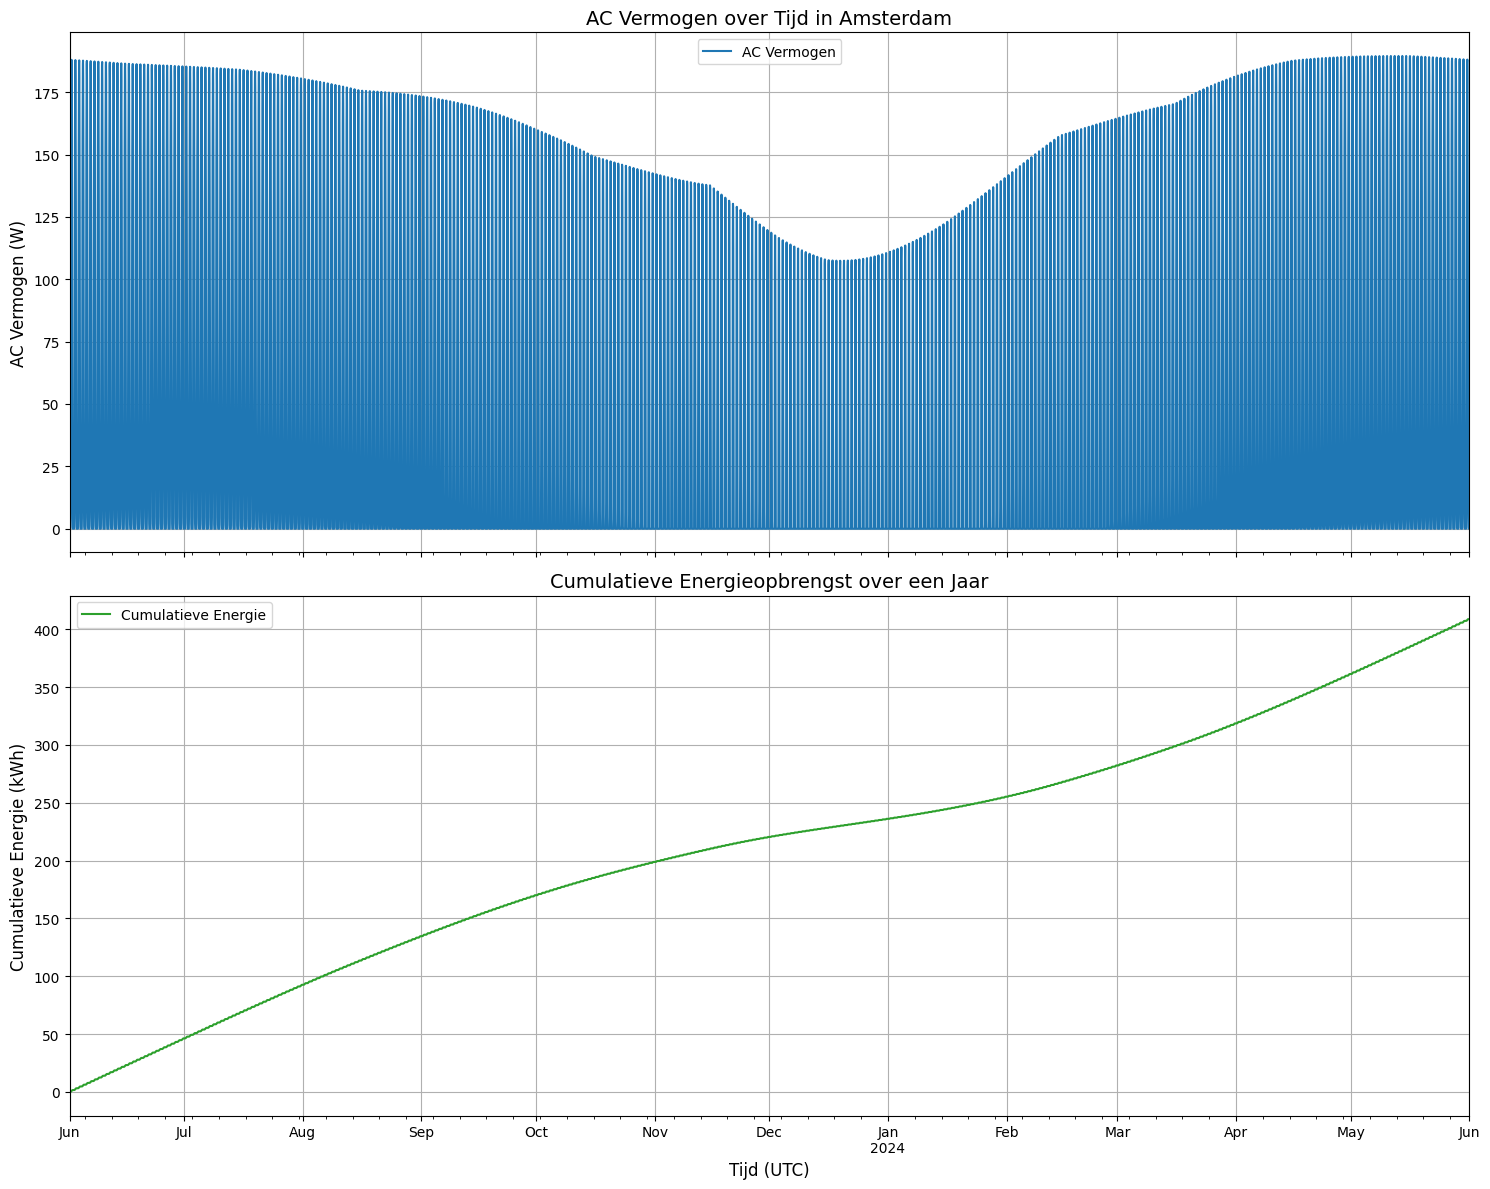

In [3]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pvlib.location import Location

# Gegevens voor Amsterdam
latitude_amsterdam = 52.3676
longitude_amsterdam = 4.9041
timezone_amsterdam = 'Europe/Amsterdam'
name_amsterdam = 'Amsterdam'

# Initialiseer locatie
location_amsterdam = Location(
    latitude=latitude_amsterdam, 
    longitude=longitude_amsterdam, 
    tz=timezone_amsterdam, 
    name=name_amsterdam
)

# Definieer de tijdstippen in UTC over een jaar
times = pd.date_range(start='2023-06-01', end='2024-06-01', freq='1H', tz='UTC')

# Bereken de zonnepositie en clear-sky straling
solar_position_amsterdam = location_amsterdam.get_solarposition(times)
clearsky_amsterdam = location_amsterdam.get_clearsky(times, model='ineichen')

# Voeg temperatuur en windsnelheid toe aan de weergegevens
weather_amsterdam = clearsky_amsterdam.copy()
weather_amsterdam['temp_air'] = 15  # Luchttemperatuur in graden Celsius
weather_amsterdam['wind_speed'] = 2  # Windsnelheid in m/s

# Haal module- en omvormerparameters op
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

# Definieer PV-systeem
system_amsterdam = pvlib.pvsystem.PVSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_parameters=module,
    inverter_parameters=inverter,
    module_type='glass_polymer',
    racking_model='open_rack'
)

# Maak ModelChain-object en voer berekeningen uit
mc_amsterdam = pvlib.modelchain.ModelChain(system_amsterdam, location_amsterdam)
mc_amsterdam.run_model(weather_amsterdam)

# Haal de AC-vermogenoutput op
ac_power_amsterdam = mc_amsterdam.results.ac

# Bereken de totale energieopbrengst in kWh
energy_amsterdam = ac_power_amsterdam.sum() / 1000  # van Wh naar kWh

# Print de resultaten
print(f"Totale jaarlijkse energieopbrengst voor {name_amsterdam}: {energy_amsterdam:.2f} kWh")

# Visualiseer de resultaten
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# AC Vermogen over tijd
ac_power_amsterdam.plot(ax=axes[0], label='AC Vermogen', color='tab:blue')
axes[0].set_ylabel('AC Vermogen (W)', fontsize=12)
axes[0].set_title(f'AC Vermogen over Tijd in {name_amsterdam}', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# Cumulatieve energieopbrengst
cumulative_energy_amsterdam = ac_power_amsterdam.cumsum() / 1000  # in kWh
cumulative_energy_amsterdam.plot(ax=axes[1], label='Cumulatieve Energie', color='tab:green')
axes[1].set_ylabel('Cumulatieve Energie (kWh)', fontsize=12)
axes[1].set_xlabel('Tijd (UTC)', fontsize=12)
axes[1].set_title('Cumulatieve Energieopbrengst over een Jaar', fontsize=14)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [4]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pvlib.location import Location

def simulate_pv_system(location_name, latitude, longitude, timezone, surface_tilt, surface_azimuth, temp_air, wind_speed, start_date, end_date):
    """
    Simuleer een PV-systeem en retourneer de resultaten.

    Parameters:
    - location_name: Naam van de locatie (str)
    - latitude: Breedtegraad (float)
    - longitude: Lengtegraad (float)
    - timezone: Tijdzone (str)
    - surface_tilt: Hellingshoek van de panelen (float, in graden)
    - surface_azimuth: Oriëntatie van de panelen (float, in graden)
    - temp_air: Luchttemperatuur (float, in °C)
    - wind_speed: Windsnelheid (float, in m/s)
    - start_date: Startdatum van de simulatie (str, 'YYYY-MM-DD')
    - end_date: Einddatum van de simulatie (str, 'YYYY-MM-DD')

    Returns:
    - results: DataFrame met de AC-vermogenoutput en cumulatieve energieopbrengst.
    - totale_energie: Totale energieopbrengst in kWh.
    """

    # Initialiseer locatie
    location = Location(latitude=latitude, longitude=longitude, tz=timezone, name=location_name)

    # Definieer de tijdstippen in UTC
    times = pd.date_range(start=start_date, end=end_date, freq='1H', tz='UTC')

    # Bereken de clear-sky straling
    clearsky = location.get_clearsky(times, model='ineichen')

    # Voeg temperatuur en windsnelheid toe aan de weergegevens
    weather = clearsky.copy()
    weather['temp_air'] = temp_air
    weather['wind_speed'] = wind_speed

    # Haal module- en omvormerparameters op
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
    inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

    # Definieer PV-systeem
    system = pvlib.pvsystem.PVSystem(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        module_parameters=module,
        inverter_parameters=inverter,
        module_type='glass_polymer',
        racking_model='open_rack'
    )

    # Maak ModelChain-object en voer berekeningen uit
    mc = pvlib.modelchain.ModelChain(system, location)
    mc.run_model(weather)

    # Haal de AC-vermogenoutput op
    ac_power = mc.results.ac

    # Bereken cumulatieve energieopbrengst
    cumulative_energy = ac_power.cumsum() / 1000  # in kWh
    totale_energie = ac_power.sum() / 1000  # in kWh

    # Combineer resultaten in een DataFrame
    results = pd.DataFrame({
        'ac_power': ac_power,
        'cumulative_energy': cumulative_energy
    })

    return results, totale_energie


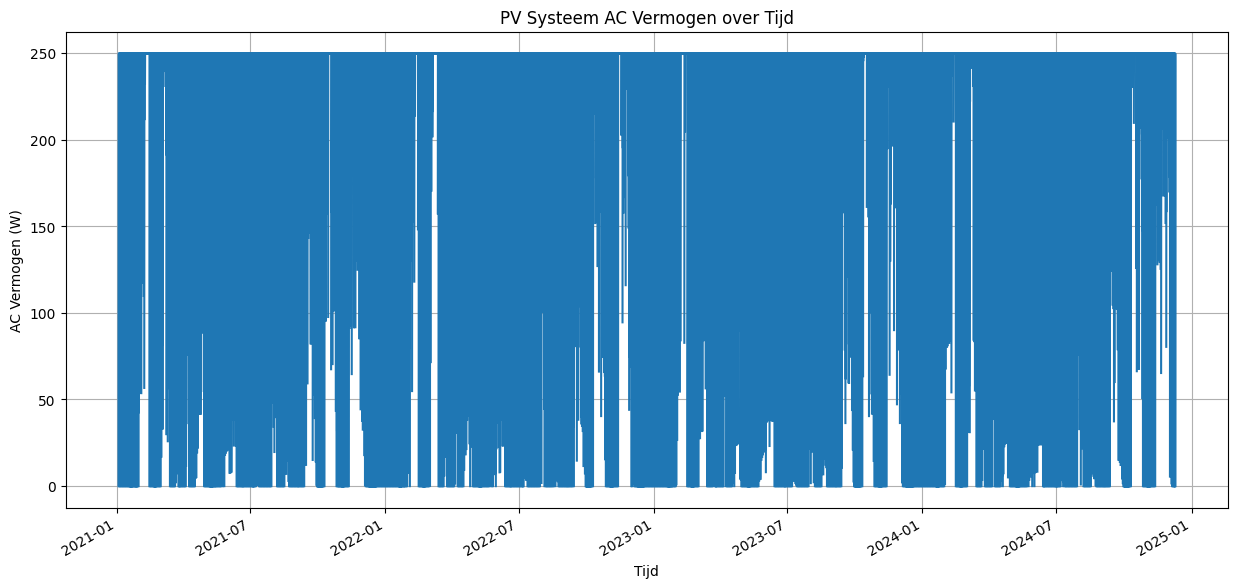

Totale geschatte zonne-energieopbrengst: 3785.93 kWh


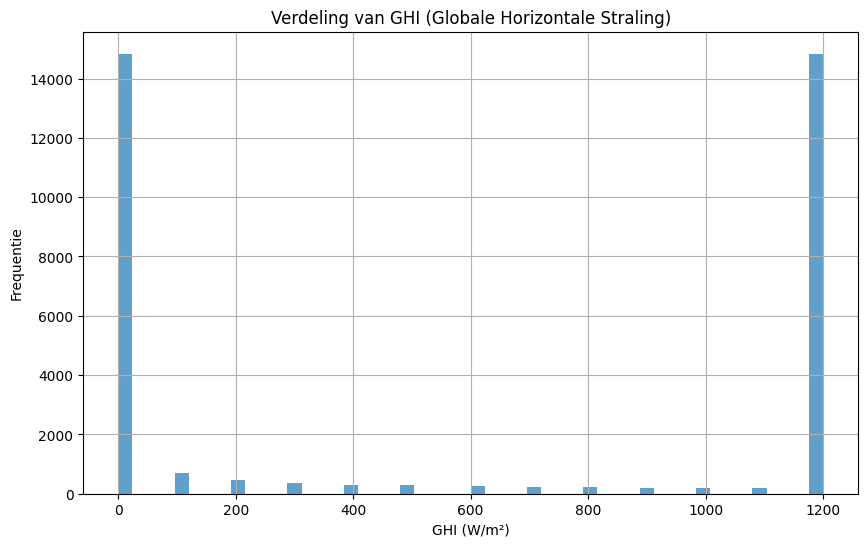

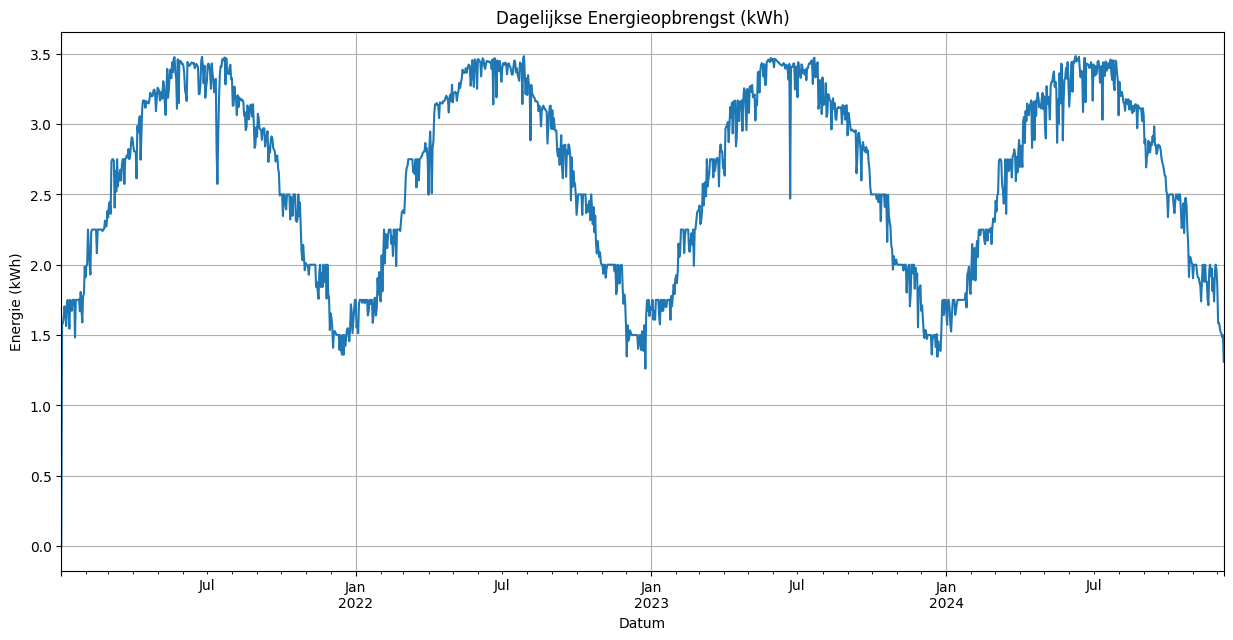

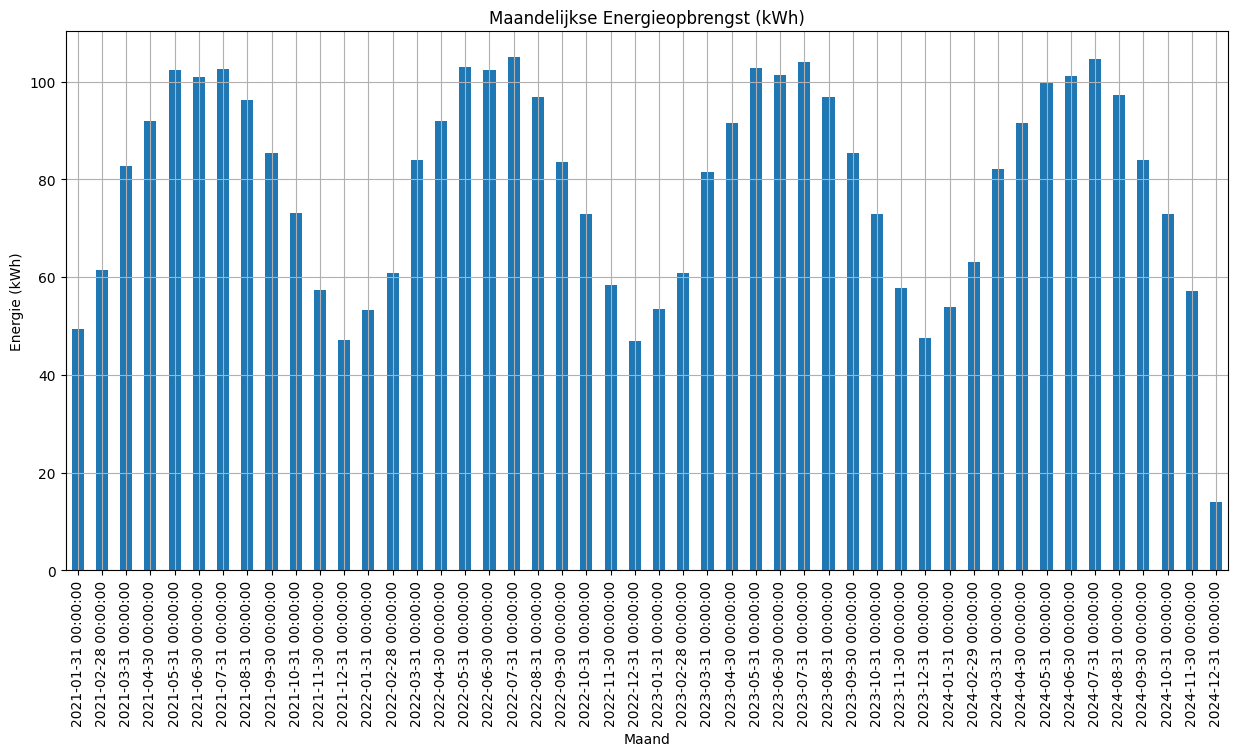

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

# Inlezen van de data
file_path = "data/KNMI_weerdata.txt"
data = pd.read_csv(
    file_path, 
    skiprows=71,  # Header overslaan
    delimiter=',', 
    names=['STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10N', 'TD', 'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S', 'O', 'Y'],
    na_values=['     ', '-1']  # Missing values
)

# Datum en tijd combineren
data['datetime'] = pd.to_datetime(
    data['YYYYMMDD'].astype(str) + data['HH'].astype(str).str.zfill(2), 
    format='%Y%m%d%H', 
    errors='coerce'  # Converteer fouten naar NaT
)
data = data.dropna(subset=['datetime'])  # Verwijder rijen met ongeldige datums
data.set_index('datetime', inplace=True)

# Data opschonen
# Zet temperatuur en globale straling om naar bruikbare eenheden
data['temperature'] = data['T'] / 10.0  # Van 0.1 graden Celsius naar graden Celsius
data['global_radiation'] = data['Q'] / 10.0  # Van J/cm^2 naar kJ/m^2 (ongeveer)

# Bereken solar position
solar_position = pvlib.solarposition.get_solarposition(
    time=data.index,
    latitude=52.3676,
    longitude=4.9041,
    altitude=0,
    pressure=101325,
    temperature=data['temperature']
)

# Bereken DNI vanuit GHI en solar zenith
dni = pvlib.irradiance.dirint(
    ghi=data['global_radiation'] * 1000,  # Van kJ/m^2 naar W/m^2
    solar_zenith=solar_position['apparent_zenith'],
    times=data.index
)

# Bereken DHI als verschil
ghi = data['global_radiation'] * 1000  # GHI in W/m^2
dhi = ghi - dni * pvlib.tools.cosd(solar_position['apparent_zenith'])

# Voeg extra kolommen toe voor PVLib
weather = pd.DataFrame({
    'temp_air': data['temperature'],
    'ghi': ghi.clip(upper=1200),  # Outliers filteren
    'dni': dni.clip(lower=0, upper=1200),
    'dhi': dhi.clip(lower=0, upper=1200),
    'wind_speed': data['FH'] / 10.0  # Van 0.1 m/s naar m/s
}, index=data.index)

# PV-systeem parameters
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

system = pvlib.pvsystem.PVSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_parameters=module,
    inverter_parameters=inverter,
    module_type='glass_polymer',
    racking_model='open_rack'
)

location = pvlib.location.Location(
    latitude=52.3676,
    longitude=4.9041,
    tz="Europe/Amsterdam",
    altitude=0
)

# Bereken zonne-opbrengst
mc = pvlib.modelchain.ModelChain(system, location)
mc.run_model(weather)

# Verkrijg resultaten
ac_power = mc.results.ac

# Plot resultaten
ac_power.plot(
    figsize=(15, 7),
    title='PV Systeem AC Vermogen over Tijd',
    ylabel='AC Vermogen (W)',
    xlabel='Tijd',
    grid=True
)
plt.show()

# Totale energieopbrengst berekenen
total_energy = ac_power.sum() / 1000  # Van Wh naar kWh
print(f'Totale geschatte zonne-energieopbrengst: {total_energy:.2f} kWh')

# Verdeling van GHI
weather['ghi'].hist(bins=50, figsize=(10, 6), alpha=0.7)
plt.title("Verdeling van GHI (Globale Horizontale Straling)")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Frequentie")
plt.grid(True)
plt.show()

# Dagelijkse energieopbrengst
daily_energy = ac_power.resample('D').sum() / 1000  # Dagelijkse energie in kWh
daily_energy.plot(
    figsize=(15, 7),
    title="Dagelijkse Energieopbrengst (kWh)",
    ylabel="Energie (kWh)",
    xlabel="Datum",
    grid=True
)
plt.show()

# Maandelijkse energieopbrengst
monthly_energy = ac_power.resample('M').sum() / 1000  # Maandelijkse energie in kWh
monthly_energy.plot(
    kind='bar',
    figsize=(15, 7),
    title="Maandelijkse Energieopbrengst (kWh)",
    ylabel="Energie (kWh)",
    xlabel="Maand",
    grid=True
)
plt.show()
